# Fraud Detection

This project deals with the detection of fradulent transcations from a bank account. It has been achieved by training Isolation Forest and Local Outlier Factor models. We have printed out 10 fradulent cases identified by each of the model as result.

#### Importing Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

transactionsdf = pd.read_csv('lab4train.csv',  sep=',', names=['Transaction ID', 'Client ID', 'Transaction value', 'Merchant ID', 'Date Counter', 'Time', 'Fraud Detection Flag'])
transactionsdf.head()

,Transaction ID,Client ID,Transaction value,Merchant ID,Date Counter,Time,Fraud Detection Flag
0,1,340,29756,2023,0,22,0
1,2,227,3318,84,0,66,0
2,3,430,12191,814,0,128,0
3,4,142,2884,510,0,197,0
4,5,452,34639,1993,0,242,0


In [2]:
test_transactionsdf = pd.read_csv('lab4test.csv',  sep=',', names=['Transaction ID', 'Client ID', 'Transaction value', 'Merchant ID', 'Date Counter', 'Time', 'Fraud Detection Flag'])
test_transactionsdf.head()

,Transaction ID,Client ID,Transaction value,Merchant ID,Date Counter,Time,Fraud Detection Flag
0,1,108,3130,3276,0,9,0
1,2,217,12716,1614,0,51,0
2,3,354,2655,3994,0,104,0
3,4,285,9286,1827,0,150,0
4,5,24,11334,3878,0,196,0


#### Data Exploration

In [3]:
# Start exploring the dataset
print(transactionsdf.columns.tolist())

['Transaction ID', 'Client ID', 'Transaction value', 'Merchant ID', 'Date Counter', 'Time', 'Fraud Detection Flag']


In [4]:
# Print the shape of the data

columns = ['Client ID','Transaction value']
datadf = pd.DataFrame(transactionsdf[columns])
datadf["Time"] = transactionsdf['Date Counter']*24*60*60 + transactionsdf['Time']

data =  (datadf - datadf.mean()) / (datadf.max() - datadf.min())
data["Fraud Detection Flag"] = transactionsdf["Fraud Detection Flag"]

print(data.shape)
print(data.describe())


(100000, 4)
          Client ID  Transaction value          Time  Fraud Detection Flag
count  1.000000e+05       1.000000e+05  1.000000e+05           100000.0000
mean  -1.304443e-17      -4.636735e-17  6.849854e-17                0.0001
std    2.052305e-01       2.883872e-01  2.873679e-01                0.0100
min   -5.016610e-01      -3.445297e-01 -5.007030e-01                0.0000
25%   -1.475362e-01      -2.824408e-01 -2.508464e-01                0.0000
50%   -6.549296e-04      -1.096458e-01 -5.826173e-04                0.0000
75%    1.462264e-01       3.257578e-01  2.492874e-01                0.0000
max    4.983390e-01       6.554703e-01  4.992970e-01                1.0000


In [5]:
# Prepare test data in the same way

columns = ['Client ID','Transaction value']
test_datadf = pd.DataFrame(test_transactionsdf[columns])
test_datadf["Time"] = test_transactionsdf['Date Counter']*24*60*60 + test_transactionsdf['Time']

test_data =  (test_datadf - test_datadf.mean()) / (test_datadf.max() - test_datadf.min())
test_data["Fraud Detection Flag"] = test_transactionsdf["Fraud Detection Flag"]

print(test_data.shape)
print(test_data.describe())

# Store the variable we'll be predicting on
target = "Fraud Detection Flag"

X_test = test_data[columns]
Y_test = test_data[target]

(100000, 4)
          Client ID  Transaction value          Time  Fraud Detection Flag
count  1.000000e+05       1.000000e+05  1.000000e+05              100000.0
mean  -2.129796e-17      -3.168410e-17 -3.209266e-17                   0.0
std    2.047157e-01       2.892994e-01  2.873993e-01                   0.0
min   -4.988134e-01      -3.408575e-01 -5.012356e-01                   0.0
25%   -1.474078e-01      -2.784034e-01 -2.508207e-01                   0.0
50%   -8.214056e-04      -1.058791e-01 -1.060611e-03                   0.0
75%    1.457649e-01       3.295084e-01  2.489320e-01                   0.0
max    5.011866e-01       6.591425e-01  4.987644e-01                   0.0


#### 1. Histograms

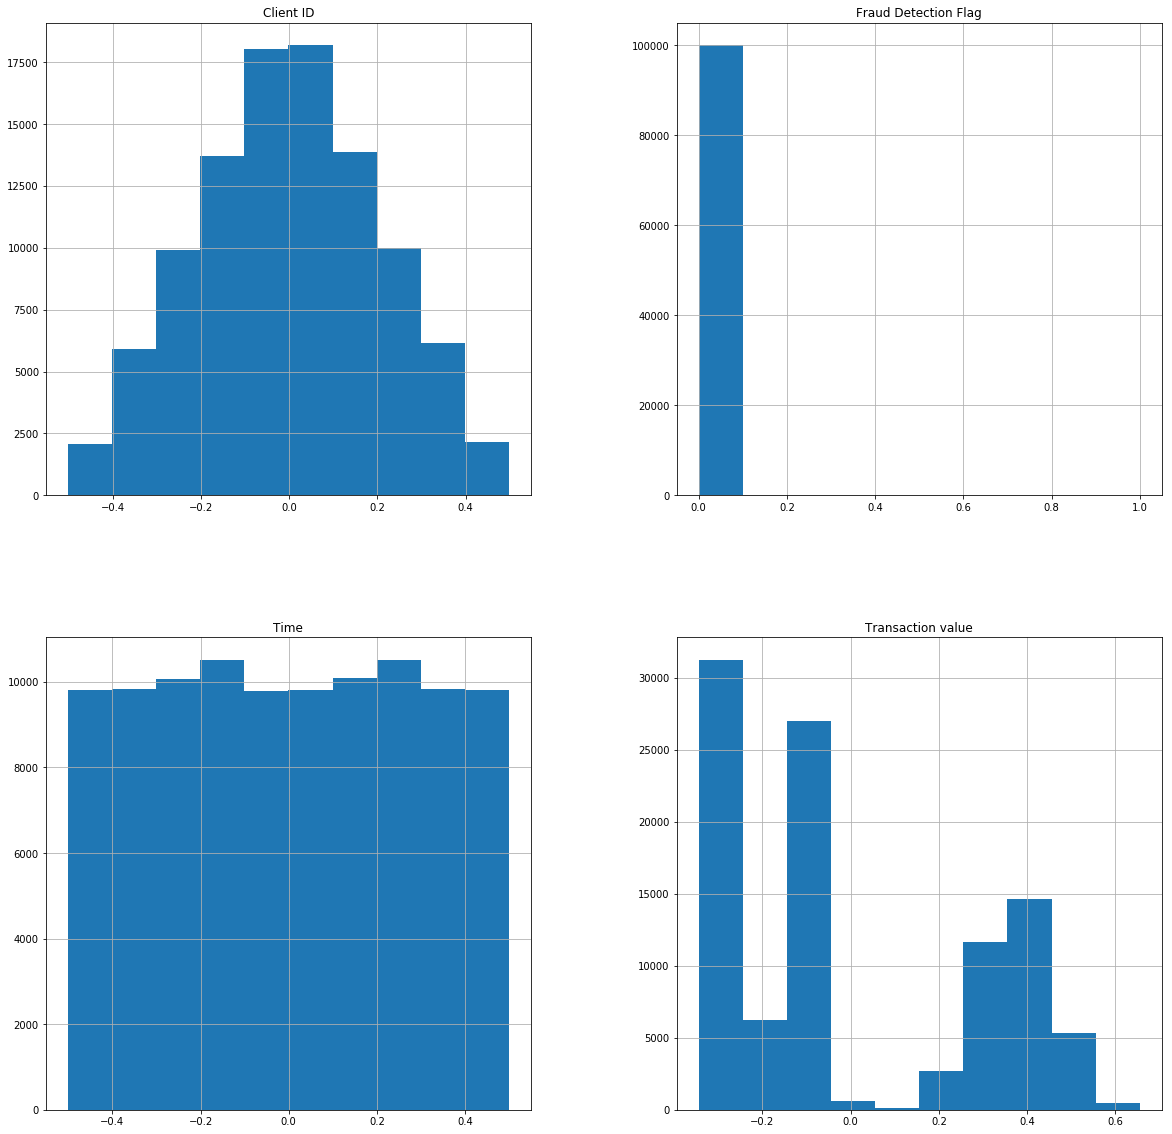

In [6]:
# Plot histograms of each parameter 
data.hist(figsize = (20, 20))
plt.show()

In [7]:
# Determine number of fraud cases in dataset

Fraud = data[data['Fraud Detection Flag'] == 1]
Valid = data[data['Fraud Detection Flag'] == 0]

outlier_fraction = len(Fraud)/float(len(Valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(data[data['Fraud Detection Flag'] == 1])))
print('Valid Transactions: {}'.format(len(data[data['Fraud Detection Flag'] == 0])))



0.00010001000100010001
Fraud Cases: 10
Valid Transactions: 99990


#### 2. Correlation Matrix

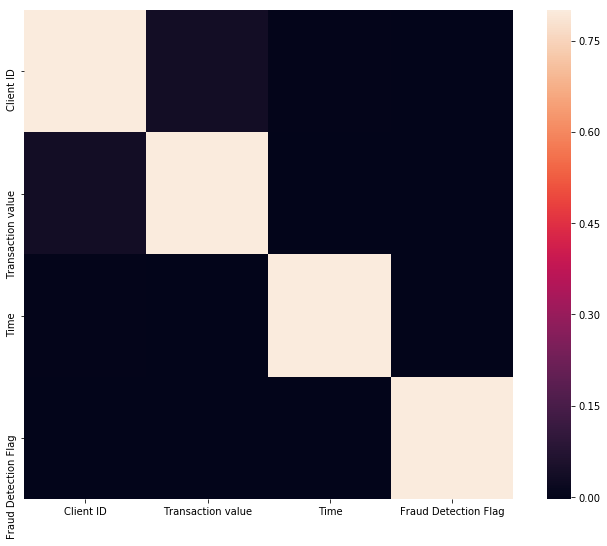

In [8]:
# Correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

#### Data Preparation

In [9]:
# Get all the columns from the dataFrame
columns = data.columns.tolist()

# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Fraud Detection Flag"]]

# Store the variable we'll be predicting on
target = "Fraud Detection Flag"

X = data[columns]
Y = data[target]

# Print shapes
print(X.shape)
print(Y.shape)

(100000, 3)
(100000,)


#### Training Models

In [10]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


# define random states
state = 1

# define outlier detection tools to be compared
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(X),
                                        contamination=outlier_fraction,
                                        random_state=state),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=20,
        contamination=outlier_fraction),
    }

In [11]:

def plot_confusion_matrix(y_test, pred):
    
    y_test_legit = y_test.value_counts()[0]
    y_test_fraud = y_test.value_counts()[1]
    
    cfn_matrix = confusion_matrix(y_test, pred)
    cfn_norm_matrix = np.array([[1.0 / y_test_legit,1.0/y_test_legit],[1.0/y_test_fraud,1.0/y_test_fraud]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)

    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    pass


#### Results: Identified Fraudulent Cases

Isolation Forest: 19
0.99981
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     99990
          1       0.09      0.10      0.10        10

avg / total       1.00      1.00      1.00    100000



<Figure size 648x504 with 0 Axes>

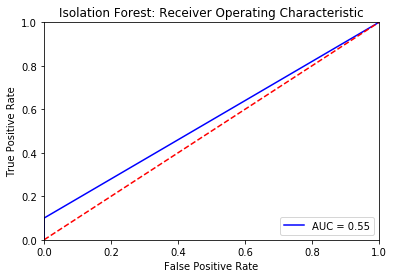

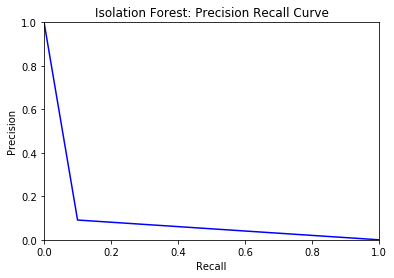

<Figure size 432x288 with 0 Axes>

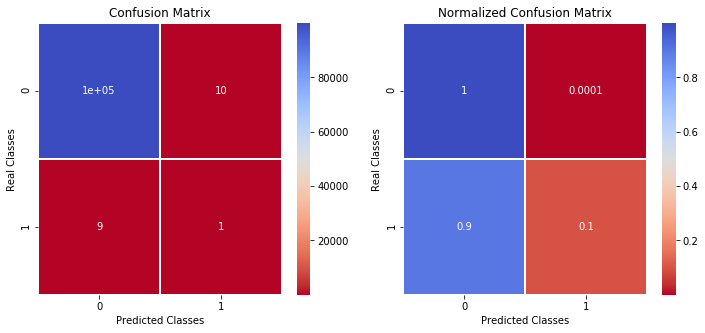

Local Outlier Factor: 17
0.99983
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     99990
          1       0.18      0.20      0.19        10

avg / total       1.00      1.00      1.00    100000



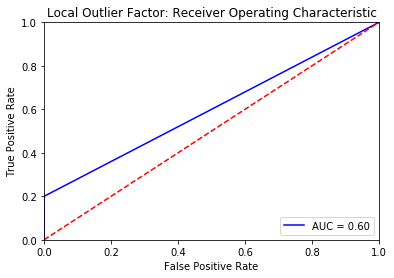

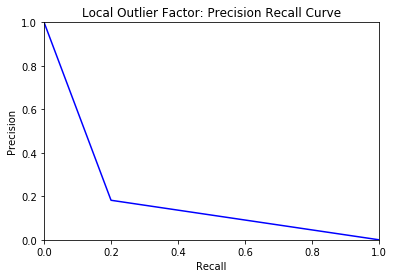

<Figure size 432x288 with 0 Axes>

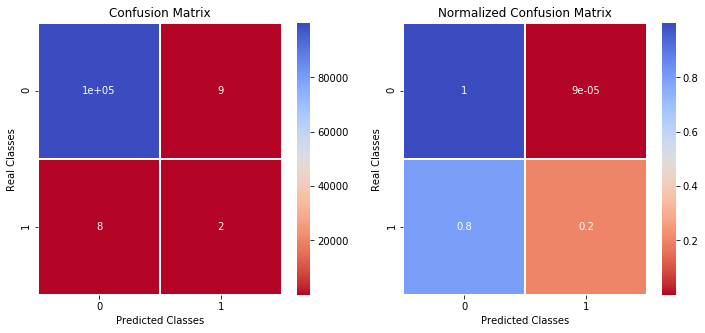

In [12]:
# Fit the model
plt.figure(figsize=(9, 7))
n_outliers = len(Fraud)


for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    elif clf_name == "Isolation Forest":
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)


    
    # Reshape the prediction values to 0 for valid, 1 for fraud. 
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != Y).sum()
    
    # Run classification metrics
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))

    fpr, tpr, thresholds = roc_curve(Y, y_pred)

    precision, recall, thresholds = precision_recall_curve(Y, y_pred)

    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.title('{}: Receiver Operating Characteristic'.format(clf_name))
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.,1.])
    plt.ylim([0.,1.])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')


    plt.figure()
    plt.title('{}: Precision Recall Curve'.format(clf_name))
    plt.plot(recall, precision, 'b')
    plt.xlim([0.,1.])
    plt.ylim([0.,1.])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    
    plt.figure()
    plot_confusion_matrix(Y, y_pred)

In [13]:
# For test dataset

predictions = []

for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_test_pred = clf.fit_predict(X_test)
        scores_pred = clf.negative_outlier_factor_
    elif clf_name == "Isolation Forest":
        clf.fit(X_test)
        scores_pred = clf.decision_function(X_test)
        y_test_pred = clf.predict(X_test)


    
    # Reshape the prediction values to 0 for valid, 1 for fraud. 
    y_test_pred[y_test_pred == 1] = 0
    y_test_pred[y_test_pred == -1] = 1
    predictions.append(y_test_pred.nonzero())
    
    

In [14]:
# Fraudulant data indices

print('For Local Outlier Factor, fraudulant transactions are at indices:')
print(predictions[0][0], '\n')
print('For Isolation Forest, fraudulant transactions are at indices:')
print(predictions[1][0], '\n')

For Local Outlier Factor, fraudulant transactions are at indices:
[10215 11880 19413 46683 52774 65886 72915 75008 85066 89132 97061] 

For Isolation Forest, fraudulant transactions are at indices:
[ 9515 16782 25825 27570 30791 45751 75008 75678 77150 86006 87236] 



In [15]:
# Fraudulant Transactions: Local Outlier Factor

fraud1 = pd.DataFrame(test_transactionsdf['Transaction ID'][predictions[0][0]], columns=['Transaction ID'])
fraud1['Client ID'] = test_transactionsdf['Client ID'][predictions[0][0]]
fraud1['Transaction value'] = test_transactionsdf['Transaction value'][predictions[0][0]]
fraud1['Merchant ID'] = test_transactionsdf['Merchant ID'][predictions[0][0]]
fraud1['Date Counter'] = test_transactionsdf['Date Counter'][predictions[0][0]]
fraud1['Time'] = test_transactionsdf['Time'][predictions[0][0]]
print('Fradulant Transactions according to Local Outlier Factor')
fraud1



Fradulant Transactions according to Local Outlier Factor


,Transaction ID,Client ID,Transaction value,Merchant ID,Date Counter,Time
10215,10216,497,45410,2487,4,77486
11880,11881,0,33201,4930,5,65482
19413,19414,11,22473,2408,9,41357
46683,46684,35,47703,2361,22,36608
52774,52775,442,48769,3115,25,2815
65886,65887,498,1599,1789,31,41385
72915,72916,250,49389,831,34,60416
75008,75009,266,565,2299,35,60314
85066,85067,433,49561,3580,40,46157
89132,89133,475,48703,4402,42,42195


In [16]:
# Fraudulant Transactions: Isolation Forest

fraud2 = pd.DataFrame(test_transactionsdf['Transaction ID'][predictions[1][0]], columns=['Transaction ID'])
fraud2['Client ID'] = test_transactionsdf['Client ID'][predictions[1][0]]
fraud2['Transaction value'] = test_transactionsdf['Transaction value'][predictions[1][0]]
fraud2['Merchant ID'] = test_transactionsdf['Merchant ID'][predictions[1][0]]
fraud2['Date Counter'] = test_transactionsdf['Date Counter'][predictions[1][0]]
fraud2['Time'] = test_transactionsdf['Time'][predictions[1][0]]
print('Fradulant Transactions according to Isolation Forest')
fraud2

Fradulant Transactions according to Isolation Forest


,Transaction ID,Client ID,Transaction value,Merchant ID,Date Counter,Time
9515,9516,183,5744,1918,4,58125
16782,16783,465,5686,2690,7,84701
25825,25826,330,6070,2148,12,43821
27570,27571,412,5674,4894,13,34074
30791,30792,444,6209,4511,14,64035
45751,45752,151,5852,4152,21,68561
75008,75009,266,565,2299,35,60314
75678,75679,40,6418,2642,35,78754
77150,77151,437,942,4577,36,61321
86006,86007,383,969,1078,40,72020
